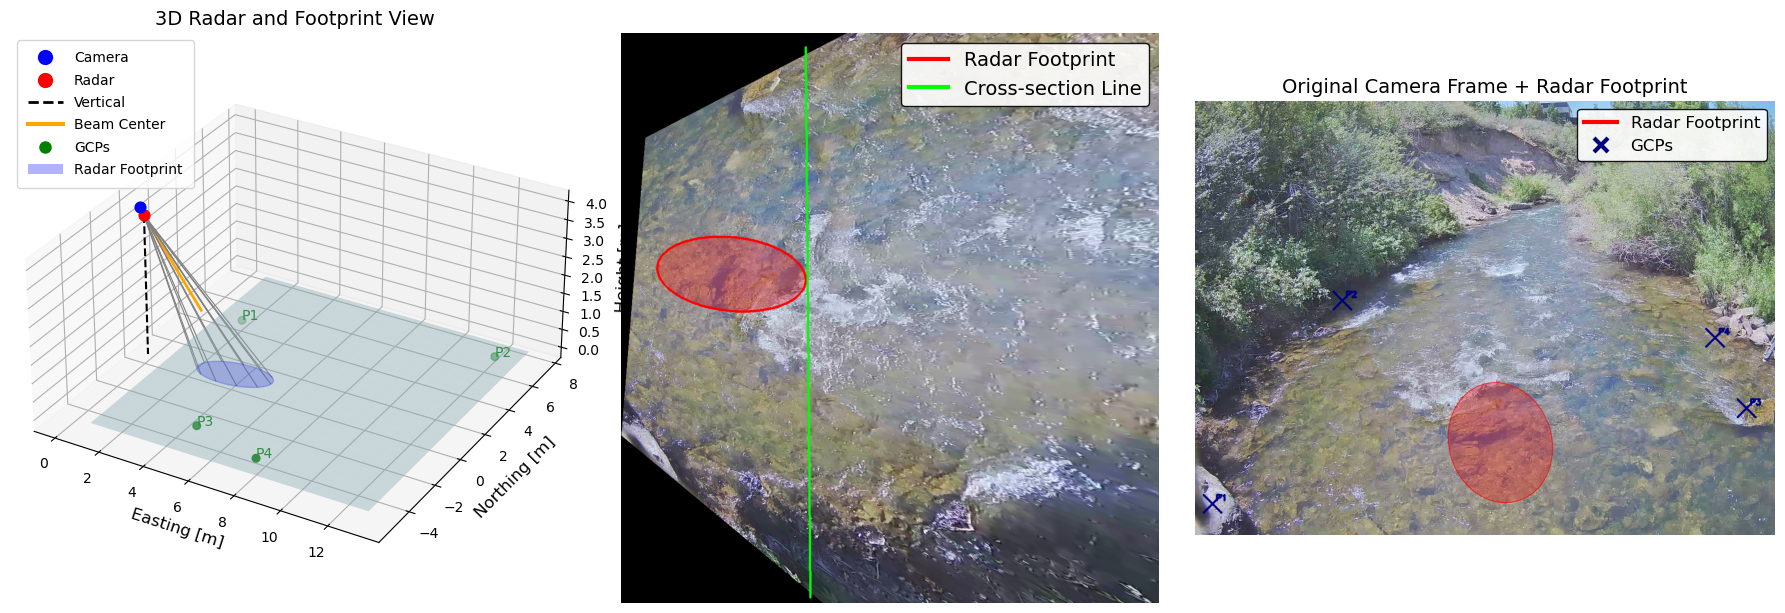

✅ Saved the 3D radar subplot separately.
✅ Saved the warped top-down subplot separately.
✅ Saved the original camera frame subplot separately.
✅ Saved complete figure with all three subplots.


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

VIDEO_PATH = "Video1.mp4"

world_pts = np.array([
    [4.060, 2.014],
    [6.555, 12.177],
    [-3.502, 4.640],
    [-4.322, 7.778]
], dtype=np.float32)

image_pts = np.array([
    [77, 1782],
    [650, 885],
    [2434, 1360],
    [2295, 1049]
], dtype=np.float32)

CAMERA_HEIGHT_M = 4.0
RADAR_OFFSET_X = 0.152
RADAR_OFFSET_Z = -0.203
RADAR_TILT_DEG = 44.0
RADAR_BEAM_AZ_DEG = 12.0
RADAR_BEAM_EL_DEG = 24.0
ELLIPSE_RES = 360

camera_pos = np.array([0.0, 0.0, CAMERA_HEIGHT_M])
radar_pos = camera_pos + np.array([RADAR_OFFSET_X, 0.0, RADAR_OFFSET_Z])
radar_height = radar_pos[2]

# Homography
world_xy = np.column_stack([world_pts[:, 1], world_pts[:, 0]]).astype(np.float32)
H_world_to_img, _ = cv2.findHomography(world_xy, image_pts)

# Radar footprint
tilt_rad = np.deg2rad(RADAR_TILT_DEG)
d_ground = radar_height / np.tan(tilt_rad)
a = 2 * radar_height * np.tan(np.deg2rad(RADAR_BEAM_AZ_DEG / 2))
b = 2 * radar_height * np.tan(np.deg2rad(RADAR_BEAM_EL_DEG / 2))

centroid = world_xy.mean(axis=0)
v = centroid - np.array([0.0, 0.0])
v_unit = v / np.linalg.norm(v) if np.linalg.norm(v) > 1e-6 else np.array([0.0, 1.0])
footprint_center = v_unit * d_ground

theta = np.linspace(0, 2*np.pi, ELLIPSE_RES)
ellipse_local = np.column_stack([a * np.cos(theta), b * np.sin(theta)])
e_along = v_unit
e_perp = np.array([-e_along[1], e_along[0]])
ellipse_world = footprint_center + ellipse_local[:, 0:1]*e_perp + ellipse_local[:,1:2]*e_along

ellipse_world_pts = ellipse_world.reshape(1,-1,2).astype(np.float32)
ellipse_img_pts = cv2.perspectiveTransform(ellipse_world_pts, H_world_to_img)[0]
ellipse_img_pts_int = np.round(ellipse_img_pts).astype(np.int32)

# Read frame
cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Cannot read frame from video.")
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
H_img, W_img = frame.shape[:2]

# Overlay radar on camera frame
mask_img = np.zeros((H_img, W_img), dtype=np.uint8)
ellipse_clipped = ellipse_img_pts_int.copy()
ellipse_clipped[:,0] = np.clip(ellipse_clipped[:,0],0,W_img-1)
ellipse_clipped[:,1] = np.clip(ellipse_clipped[:,1],0,H_img-1)
cv2.fillPoly(mask_img,[ellipse_clipped],255)
mask_bool = mask_img.astype(bool)
overlay = frame_rgb.copy()
overlay[mask_bool] = (0.7*overlay[mask_bool] + 0.3*np.array([255,0,0])).astype(np.uint8)
cv2.polylines(overlay,[ellipse_clipped],True,(255,0,0),2)

for i, pt in enumerate(image_pts):
    cv2.drawMarker(overlay, tuple(pt.astype(int)), color=(0,0,128), markerType=cv2.MARKER_TILTED_CROSS, markerSize=80, thickness=8)
    cv2.putText(overlay,f"P{i+1}",(int(pt[0]+15),int(pt[1]-15)),cv2.FONT_HERSHEY_SIMPLEX,1.2,(0,0,128),8)

# Warp top-down
world_xy_cm = world_xy*100
min_vals = world_xy_cm.min(axis=0)
world_pts_trans = world_xy_cm - min_vals + 50
H_img_to_world_trans,_ = cv2.findHomography(image_pts, world_pts_trans)
warp_w = int(np.max(world_pts_trans[:,0])+100)
warp_h = int(np.max(world_pts_trans[:,1])+100)
frame_warped = cv2.warpPerspective(frame_rgb,H_img_to_world_trans,(warp_w,warp_h))

ellipse_img_pts_float = ellipse_img_pts.reshape(1,-1,2).astype(np.float32)
ellipse_warped = cv2.perspectiveTransform(ellipse_img_pts_float,H_img_to_world_trans)[0].astype(np.int32)

overlay_warped_rgb = frame_warped.copy()
mask_warped = np.zeros_like(frame_warped[:,:,0],dtype=np.uint8)
cv2.fillPoly(mask_warped,[ellipse_warped],255)
mask_bool_warped = mask_warped.astype(bool)
overlay_warped_rgb[mask_bool_warped] = (0.7*overlay_warped_rgb[mask_bool_warped] + 0.3*np.array([255,0,0])).astype(np.uint8)
cv2.polylines(overlay_warped_rgb,[ellipse_warped],True,(255,0,0),4)

# --- ADD CROSS-SECTION LINE TO WARPED IMAGE ---
# Draw cross-section line from (400, 10) to (450, 1180)
cross_start = (400, 30)
cross_end = (410, 1225)

# Professional color for cross-section (cyan for good contrast with red radar footprint)
CROSS_SECTION_COLOR = (0, 255, 0)  # Cyan color for cross-section

# Draw cross-section line (thicker for visibility)
cv2.line(overlay_warped_rgb, cross_start, cross_end, color=CROSS_SECTION_COLOR, thickness=4)

# --- PLOT 3D
xx = np.linspace(np.min(world_xy[:,0])-1,np.max(world_xy[:,0])+1,20)
yy = np.linspace(np.min(world_xy[:,1])-1,np.max(world_xy[:,1])+1,20)
XX,YY = np.meshgrid(xx,yy)
ZZ = np.zeros_like(XX)

fig = plt.figure(figsize=(18,6))
ax3d = fig.add_subplot(1,3,1,projection='3d')
ax3d.plot_surface(XX,YY,ZZ,color='lightblue',alpha=0.4)
ax3d.scatter(*camera_pos,color='blue',s=60)
ax3d.scatter(*radar_pos,color='red',s=60)
ax3d.plot([radar_pos[0],radar_pos[0]],[radar_pos[1],radar_pos[1]],[radar_pos[2],0],color='black',linestyle='--',linewidth=1.5)
beam_dir = np.array([0,np.cos(tilt_rad),-np.sin(tilt_rad)])
beam_dir /= np.linalg.norm(beam_dir)
t = radar_pos[2]/abs(beam_dir[2])
beam_end = radar_pos + beam_dir*t
ax3d.plot([radar_pos[0],beam_end[0]],[radar_pos[1],beam_end[1]],[radar_pos[2],beam_end[2]],color='orange',linewidth=2)
for idx in np.linspace(0,ELLIPSE_RES-1,12,dtype=int):
    xw,yw = ellipse_world[idx]
    ax3d.plot([radar_pos[0],xw],[radar_pos[1],yw],[radar_pos[2],0],color='gray',linewidth=0.8)
ax3d.scatter(world_xy[:,0],world_xy[:,1],np.zeros_like(world_xy[:,0]),color='green',s=30)
for i,(x,y) in enumerate(world_xy):
    ax3d.text(x,y,0.01,f"P{i+1}",color='green')
ax3d.add_collection3d(Poly3DCollection([list(zip(ellipse_world[:,0],ellipse_world[:,1],np.zeros_like(ellipse_world[:,0])))],
                                       alpha=0.3,color='blue'))

ax3d.set_title("3D Radar and Footprint View", fontsize=14)
ax3d.set_xlabel("Easting [m]", fontsize=12); ax3d.set_ylabel("Northing [m]", fontsize=12); ax3d.set_zlabel("Height [m]", fontsize=12)
ax3d.set_box_aspect([1,1,0.5])

# Increase tick label sizes
ax3d.tick_params(axis='x', labelsize=10)
ax3d.tick_params(axis='y', labelsize=10)
ax3d.tick_params(axis='z', labelsize=10)

proxy_artists = [
    Line2D([0],[0],marker='o',color='w',markerfacecolor='blue',markersize=12,label='Camera'),
    Line2D([0],[0],marker='o',color='w',markerfacecolor='red',markersize=12,label='Radar'),
    Line2D([0],[0],color='black',linestyle='--',linewidth=2,label='Vertical'),
    Line2D([0],[0],color='orange',linewidth=3,label='Beam Center'),
    Line2D([0],[0],color='green',marker='o',linestyle='None',markersize=8,label='GCPs'),
    Patch(facecolor='blue',alpha=0.3,label='Radar Footprint')
]

# Increase legend size for plot 1
ax3d.legend(handles=proxy_artists, loc='upper left', fontsize=10, 
            borderpad=0.8, labelspacing=0.6, handlelength=2.5)

# --- Warped top-down
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(overlay_warped_rgb)

# Create custom legend elements for the warped plot
warped_legend_elements = [
    Line2D([0], [0], color=(255/255, 0/255, 0/255), lw=3, label='Radar Footprint'),
    Line2D([0], [0], color=(0/255, 255/255, 0/255), lw=3, label='Cross-section Line'),
]

# Add legend to the warped plot - moved to top right and made bigger
ax2.legend(handles=warped_legend_elements, loc='upper right', fontsize=14, 
           facecolor='white', edgecolor='black', framealpha=0.9)

ax2.axis('off')  # Title removed as requested

# --- Original camera frame
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(overlay)
ax3.set_title("Original Camera Frame + Radar Footprint", fontsize=14)
ax3.axis('off')

# Add legend for the original camera frame
original_legend_elements = [
    Line2D([0], [0], color=(255/255, 0/255, 0/255), lw=3, label='Radar Footprint'),
    Line2D([0], [0], color=(0/255, 0/255, 128/255), marker='x', linestyle='None', 
           markersize=10, markeredgewidth=3, label='GCPs'),
]

# Increase legend size for plot 3
ax3.legend(handles=original_legend_elements, loc='upper right', fontsize=12, 
           facecolor='white', edgecolor='black', framealpha=0.9)

# --- SHOW FIGURE ---
plt.tight_layout()
plt.show()

# -------------------------
# Save the 1st subplot (3D radar view) separately
# -------------------------
ax3d_subplot = fig.axes[0]  # first subplot (3D radar)
extent_3d = ax3d_subplot.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

# Save only the 3D radar subplot in high quality
fig.savefig("3D_radar_view.png", dpi=600, bbox_inches=extent_3d)
print("✅ Saved the 3D radar subplot separately.")

# -------------------------
# Save the 2nd subplot (Warped top-down with cross-section)
# -------------------------
ax2_subplot = fig.axes[1]  # second subplot (warped top-down)
extent_warped = ax2_subplot.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

# Save only the warped subplot in high quality
fig.savefig("warped_topdown_cross_section.png", dpi=600, bbox_inches=extent_warped)
print("✅ Saved the warped top-down subplot separately.")

# -------------------------
# Save the 3rd subplot (Original camera frame)
# -------------------------
ax3_subplot = fig.axes[2]  # third subplot (original camera frame)
extent_original = ax3_subplot.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

# Save only the original camera subplot in high quality
fig.savefig("original_camera_frame.png", dpi=600, bbox_inches=extent_original)
print("✅ Saved the original camera frame subplot separately.")

# Also save the entire figure if needed
fig.savefig("complete_figure.png", dpi=600, bbox_inches='tight')
print("✅ Saved complete figure with all three subplots.")